# Testing posterior estimators in the LFI context

In [25]:
# Importing all packages
# normalizing flows packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import normflows as nf

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore
from CP2LFI.simulations import Simulations, naive, predict_naive_quantile
from CP2LFI.posterior_models import normflow_posterior

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# package to simulate from weinberg LFI data
# weinberg data (physics)
from hypothesis.benchmark import weinberg
# mg1 data (queue theory)
from hypothesis.benchmark import mg1
# multivariate normal (toy example)
from hypothesis.benchmark import tractable

## Organizing preliminary functions and classes first:

In [26]:
# creating all used statistics scores
# waldo score 
class WaldoScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self

    def compute(self, thetas, X, N = 10**4, one_sample = False):
        # simulating from each theta and dataset to compute waldo statistic
        i = 0
        lambdas = np.zeros(thetas.shape[0])
        
        for theta in tqdm(thetas, desc = "Computing waldo statistics using posterior model"):
            if not one_sample:
                # simulating from the model
                s = self.base_model.sample(X = X[i, :], num_samples = N)
                
                # computing E[theta|X]
                mean_theta_X = np.mean(s, axis = 0)
                var_theta_x = np.cov(s, rowvar = False)

                # computing waldo statistic
                if mean_theta_X.ndim > 1:
                    lambdas[i] = (mean_theta_X - theta).transpose() @ np.linalg.inv(var_theta_x) @ (mean_theta_X - theta)
                else:
                    lambdas[i] = (mean_theta_X - theta)**2/(var_theta_x)
                i += 1
            else:
                # simulating from the model
                s = self.base_model.sample(X = X, num_samples = N)
                
                # computing E[theta|X]
                mean_theta_X = np.mean(s, axis = 0)
                var_theta_x = np.cov(s, rowvar = False)

                # computing waldo statistic
                if mean_theta_X.ndim > 1:
                    lambdas[i] = (mean_theta_X - theta).transpose() @ np.linalg.inv(var_theta_x) @ (mean_theta_X - theta)
                else:
                    lambdas[i] = (mean_theta_X - theta)**2/(var_theta_x)
                i += 1

        return lambdas

    def predict(self, thetas_grid, X, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        # predicting lambdas for all thetas
        lambdas = self.compute(thetas_grid, X, one_sample = True)
        idxs = list(np.where(lambdas <= cutoffs)[0])

        return thetas_grid.squeeze()[idxs]

class BFFScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self

    def compute(self, thetas, X, one_sample = False):
        # simulating from each theta and dataset to compute waldo statistic
        # predicting posterior density for X and theta
        if not one_sample:
            return -self.base_model.predict(thetas, X)
        else:
            X_tile = np.tile(X, (thetas.shape[0], 1))
            return -self.base_model.predict(thetas, X_tile)

    def predict(self, thetas_grid, X, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        # predicting lambdas for all thetas
        lambdas = self.compute(thetas_grid, X, one_sample = True)
        idxs = list(np.where(lambdas <= cutoffs)[0])

        return thetas_grid.squeeze()[idxs]

class E_valueScore(Scores):
    def fit(self, X = None, thetas = None):
        # setting up model for normalizing flows
        if self.is_fitted:
            return self
        elif self.base_model is not None:
            self.base_model.fit(X, thetas)
        else:
            return self
        
    def compute(self, thetas, X, N = 10**4, one_sample = False):
        # simulating from each theta and dataset to compute waldo statistic
        i = 0
        lambdas = np.zeros(thetas.shape[0])
        
        for theta in tqdm(thetas, desc = "Computing e-value statistics using posterior model"):
            if not one_sample:
                # simulating from the posterior for each X
                s = self.base_model.sample(X = X[i, :], num_samples = N)

                # computing probability for each sample
                prob_s = self.base_model.predict(s, np.tile(X[i, :], (N, 1)))

                # compute probability for theta
                prob_theta = self.base_model.predict(theta, X[i, :].reshape(1, -1))
            else:
                # simulating from the posterior for each X
                s = self.base_model.sample(X = X, num_samples = N)

                # computing probability for each sample
                prob_s = self.base_model.predict(s, np.tile(X, (N, 1)))

                # compute probability for theta
                prob_theta = self.base_model.predict(theta, X.reshape(1, -1))

            # computing e-value
            lambdas[i] = np.mean(prob_s >= prob_theta)
            i += 1

        return lambdas
    
    def predict(self, thetas_grid, X, cutoffs):
        # TODO: grid with thetas and cutoffs to generate set
        # predicting lambdas for all thetas
        lambdas = self.compute(thetas_grid, X, one_sample = True)
        idxs = list(np.where(lambdas <= cutoffs)[0])

        return thetas_grid.squeeze()[idxs]

## Starting by a visible example:

Simulating and testing for tractable:

In [27]:
simulator = weinberg.Simulator()
prior = weinberg.Prior()

Setting $n = 25$ and $B^{'} = 20000$ for posterior modeling:

In [29]:
B_model = 20000
n = 25
torch.manual_seed(45)
# simulating thetas
thetas = prior.sample((B_model, ))
repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)

# simulating X's
X_sample = simulator(repeated_thetas)
X_sample

tensor([[ 0.4799],
        [-0.9276],
        [-0.9616],
        ...,
        [ 0.7466],
        [ 0.0651],
        [-0.6840]])

In [30]:
X_dim = X_sample.shape[1]
X_net = X_sample.reshape(B_model, n * X_dim)

In [31]:
X_net.shape

torch.Size([20000, 25])

In [32]:
thetas.reshape(-1, 1)

tensor([[0.6869],
        [1.4613],
        [1.1834],
        ...,
        [0.5894],
        [1.2994],
        [1.2105]])

Fitting normalizing flow model:

In [33]:
# reshaping thetas
thetas = thetas.reshape(-1, 1)
nflow_post = normflow_posterior(
    latent_size = thetas.shape[1],
    sample_size = X_net.shape[1], 
    n_flows = 4, 
    hidden_units = 64, 
    hidden_layers = 2,
    enable_cuda = True,
    )

nflow_post.fit(X_net.numpy(), thetas.numpy(), patience = 100, n_epochs = 2000, batch_size = 250)

Fitting normalizing flows posterior estimator:   0%|          | 0/2000 [00:00<?, ?it/s]

Fitting normalizing flows posterior estimator:  18%|█▊        | 355/2000 [01:02<04:49,  5.68it/s]

Early stopping at epoch 355
a


normflow_posterior(latent_size=1, sample_size=25)

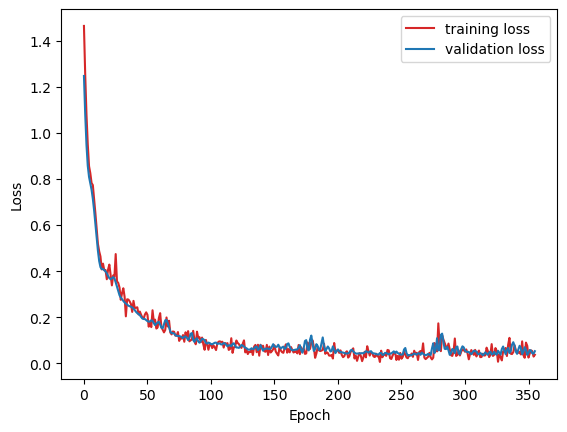

In [34]:
nflow_post.plot_history()

Simulating sample to fit confidence regions estimators:

In [40]:
# simulating to fit estimated confidence regions
B_rand = 10000
n = 25

torch.manual_seed(125)
# sampling from theta
thetas = prior.sample((B_rand, ))
repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)
X_conf = simulator(repeated_thetas)
X_dim = X_conf.shape[1]
X_net = X_conf.reshape(B_rand, n * X_dim)

In [41]:
X_net.shape

torch.Size([10000, 25])

Computing all scores dataset:

In [42]:
# reshaping array
thetas = thetas.reshape(-1, 1)

# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()
sample_waldo = waldo_score.compute(thetas.numpy(), X = X_net.numpy(), N = 1000)

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()
sample_bff = bff_score.compute(thetas.numpy(), X = X_net.numpy())

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()
sample_e_value = e_value_score.compute(thetas.numpy(), X = X_net.numpy(), N = 1000)

Computing waldo statistics using posterior model:   8%|▊         | 766/10000 [00:06<01:20, 114.81it/s]


KeyboardInterrupt: 

Fitting a fixed TRUST++ to the problem:

In [ ]:
alpha, min_samples_leaf, n_estimators, K = 0.05, 300, 200, 70

# fitting TRUST++ to waldo and visualizing
loforest_waldo = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_waldo.calibrate(
    thetas.numpy(), 
    sample_waldo, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

# fitting to BF
loforest_bf = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_bf.calibrate(
    thetas.numpy(), 
    sample_bff, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

# fitting to e-value
loforest_e_value = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_e_value.calibrate(
    thetas.numpy(), 
    sample_e_value, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

Computing confidence regions:

In [ ]:
res_thetas = np.linspace(0.5001, 1.4999, 300).reshape(-1, 1)
# waldo cutoffs
waldo_cutoffs = loforest_waldo.compute_cutoffs(res_thetas)

# bayes factor cutoffs
bf_cutoffs = loforest_bf.compute_cutoffs(res_thetas)

# e_value cutoffs
e_value_cutoffs = loforest_e_value.compute_cutoffs(res_thetas)

In [ ]:
# observed data with n = 5
torch.manual_seed(45)
theta = 1
X = simulator(np.repeat(theta, n))
X = X.squeeze().numpy()
X

array([-0.1148708,  0.8162369, -0.8814423, -0.7390032,  0.7132186],
      dtype=float32)

In [ ]:
waldo_conf = waldo_score.predict(res_thetas, X = X, cutoffs = waldo_cutoffs)
bff_conf = bff_score.predict(res_thetas, X = X, cutoffs = bf_cutoffs)
e_value_conf = e_value_score.predict(res_thetas, X = X, cutoffs = e_value_cutoffs)

Computing waldo statistics using posterior model: 100%|██████████| 300/300 [00:03<00:00, 92.24it/s]
Computing e-value statistics using posterior model: 100%|██████████| 300/300 [00:09<00:00, 30.88it/s]


In [ ]:
waldo_conf